In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from droplet_growth import fit
import json
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import poisson

%load_ext autoreload
%autoreload 2

In [2]:
intensities = pd.read_csv('/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml-rep1_1.2_cellsperdrop//intensities.csv')

print (intensities.columns)
table = pd.read_csv('/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml-rep1_1.2_cellsperdrop/20200807-CIPRO-7ngml_single cell data.csv')
print(table.columns)
positive_labels = table.query('final_state == 1').id

intensities.loc[:, 'time, h'] = intensities.time * .5
intensities.loc[:, 'experiment'] = 'CIPRO'

positive_intensities = intensities[intensities.label.isin(positive_labels) ][intensities.dye == 'RFP']

gfp_intensities = intensities[intensities.label.isin(positive_labels) ][intensities.dye == 'GFP']

# control = pd.read_csv('/home/aaristov/Multicell/SGR/20200805-Control_1.2cellsperdrop/0805-control/intensities.csv')
# control_table = pd.read_csv('/home/aaristov/Multicell/SGR/20200805-Control_1.2cellsperdrop/0805-control/202008Control_confocal.csv')
# print(control_table.columns)
# positive_labels = control_table.query('No_cells > 0')['Andrey ID']

# control.loc[:, 'time, h'] = control.time * .5
# control.loc[:, 'experiment'] = 'control'
# positive_control = control[control.label.isin(positive_labels) ]

centers = json.load(open('/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml-rep1_1.2_cellsperdrop//centers.json'))

yxl = [ {'y': (l := list(c.values()))[0][0], 'x': l[0][1], 'label': l[1]} for c in centers ]

cdf = pd.DataFrame( data=yxl)

Index(['time', 'label', 'dye', 'bg', 'raw', 'mean_intensity'], dtype='object')
Index(['coord', 'id', 'ncells', 'final_state', 'clumping', 'phenotype',
       'Unnamed: 6', 'comment', 'Unnamed: 8', 'Unnamed: 9', 'legend'],
      dtype='object')


<ipython-input-2-fc7bb24e2f62>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positive_intensities = intensities[intensities.label.isin(positive_labels) ][intensities.dye == 'RFP']
<ipython-input-2-fc7bb24e2f62>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gfp_intensities = intensities[intensities.label.isin(positive_labels) ][intensities.dye == 'GFP']


In [3]:
cdf[cdf.label == 13][['x','y']].values[0]

array([7101.53858753,  216.66123904])

In [22]:
def correct_photobleaching(label, intensities=positive_intensities, min_intensity=10, coordinates:pd.DataFrame=cdf,plot=False):
    
    print(f'well #{label}')
    print(table.query(f'id == {label}').to_string())
    intensitites = intensities.copy()
    curve = intensities.query(f'label == {label}')
    try:
        argmax = curve.mean_intensity.argmax()
        decay = curve[argmax:]
    except ValueError:
        plt.plot(curve.mean_intensity)
        plt.title(f'bad curve {label}')
        plt.show()
        return ([None] * 6, )
    
    if len(decay) < 5 or max(curve.mean_intensity) < 10:
        return ([None] * 6, )
    
    peak = decay.mean_intensity.values.max()
    
#     decay.loc[:,'normalized_intensity'] = decay.mean_intensity.values / peak
    
#     if coordinates is not None:
#         x,y = cdf[cdf.label == label][['x','y']].values[0]
#         decay.loc[:,'x'] = x
#         decay.loc[:,'y'] = y
    
    fit_result, pcov = curve_fit(fit.exponent, decay.time, decay.mean_intensity, p0=(1000, -0.01))
    
    
    corrected_curve = curve.mean_intensity.values * np.exp(-fit_result[1] * curve.time)
#     curve.loc[:, 'corrected_curve'] = corrected_curve
#     curve.loc[:, 'correction_ratio'] = fit_result[1]
    
    end_of_exp_phase = min((argmax, np.argmax(np.gradient(corrected_curve[:np.argmin(np.gradient(corrected_curve))]))))
    
    growth_curve = curve[:end_of_exp_phase]
    growth_corrected_curve = corrected_curve[:end_of_exp_phase]
    
    growth_fit = True
    fit_growth = (0,0,0)
    try:
#         fit_growth, pcov = curve_fit(fit.lin_exp_fun, growth_curve.time, growth_curve.corrected_curve, p0=(0., 1., .2, 1, 0))
        fit_growth = fit.exp_exp_fit(growth_corrected_curve)
        print(f'growth fit: {fit_growth}')
        fit_curve = fit.exp_exp_fun(growth_curve.time, 0, *fit_growth[1:])
    except ValueError:
        growth_fit = False
        plt.semilogy( corrected_curve[:argmax])
        plt.title(f'bad growth {label}')
        plt.show()
        
    
    if plot:
        curve.plot(x='time', y='mean_intensity')
        
        plt.plot(decay.time, decay.mean_intensity, '.')
        plt.plot(growth_curve.time, growth_corrected_curve - fit_growth[0], '.')
        plt.plot(decay.time, fit.exponent(decay.time, *fit_result), label=f'decay fit {fit_result[1]}')
        print(f'fit_result = {fit_result}')
        
        plt.semilogy(curve.time, corrected_curve - fit_growth[0], 'r-', label='corrected curve')
        
        if growth_fit:
            plt.semilogy(growth_curve.time, fit_curve, 
                         label=f'growth fit {fit_growth}', lw=10, alpha=0.5)
            plt.semilogy((switch := int(fit_growth[-1])), fit_curve[switch], 'o', label=f'growth switch {switch}')
            
        plt.legend(loc=(1,0))
        plt.show()
    return fit_growth, growth_curve.time, growth_corrected_curve.values, fit_curve

def bleach_fun(x, rate):
    return np.exp(- x * rate)


RFP
well #26
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9          legend
13   A14  26       1            1         1          1        NaN     NaN         NaN         NaN  0: No clumping
growth fit: [-1.99998571e+00  1.42213105e+00  3.49687715e-03  5.60255816e-01
  1.61559958e-01  1.10000000e+01]
fit_result = [ 8.12233571e+01 -1.60077444e-02]


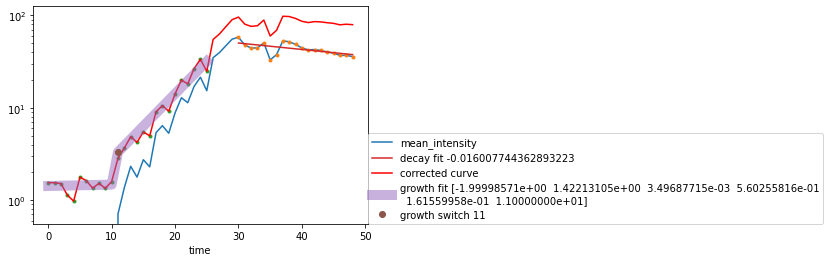

GFP
well #26
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9          legend
13   A14  26       1            1         1          1        NaN     NaN         NaN         NaN  0: No clumping
growth fit: [-1.99999999  0.95444324  0.03889143  0.25727652  0.19286334 11.        ]
fit_result = [ 5.92448212e+01 -3.42418931e-02]


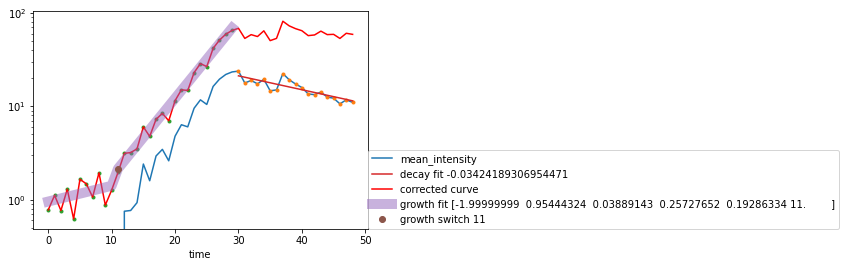

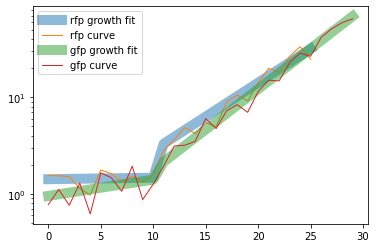

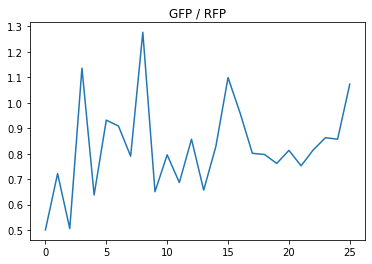

RFP
well #23
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9              legend
16   A17  23       1            1         1          1        NaN     NaN         NaN         NaN  C: Number of cells
growth fit: [-0.81199129  0.52564886  0.11302042  0.0482093   0.21213414 21.        ]
fit_result = [ 7.21962604e+01 -8.25914069e-03]


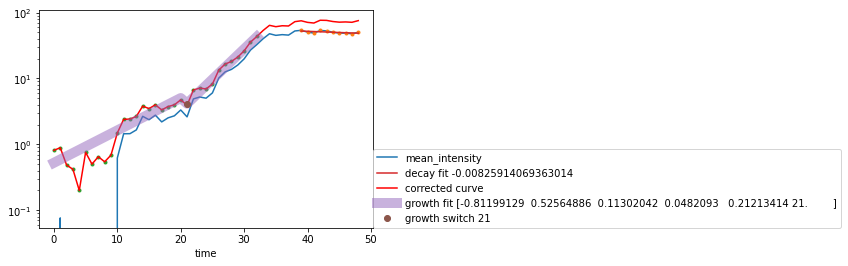

GFP
well #23
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9              legend
16   A17  23       1            1         1          1        NaN     NaN         NaN         NaN  C: Number of cells
growth fit: [-0.88169518  0.52216555  0.15942855  0.12377864  0.20935628 21.        ]
fit_result = [ 2.14954627e+02 -5.83600275e-02]


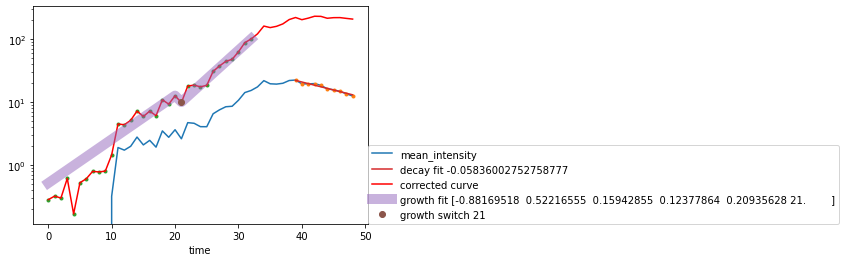

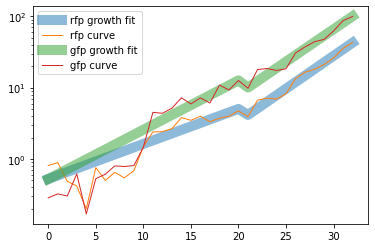

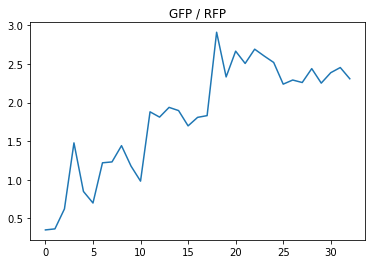

RFP
well #21
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
18   A19  21       1            1         1          1        NaN     NaN         NaN         NaN    NaN


KeyboardInterrupt: 

In [23]:
for i in table.query('final_state == 1').query('phenotype == 1').id.unique()[:5]:
    print('RFP')
    rfp_fit, rtime, rcurve, frcurve = correct_photobleaching(i, intensities=positive_intensities, plot=1)
    print('GFP')
    gfp_fit, gtime, gcurve, fgcurve = correct_photobleaching(i, intensities=gfp_intensities, plot=1)
    
    plt.semilogy( frcurve, 
                         label=f'rfp growth fit', lw=10, alpha=0.5)
    plt.semilogy( rcurve - rfp_fit[0], 
                         label=f'rfp curve', lw=1, alpha=1)
    plt.semilogy( fgcurve, 
                         label=f'gfp growth fit', lw=10, alpha=0.5)
    plt.semilogy( gcurve - gfp_fit[0], 
                         label=f'gfp curve', lw=1, alpha=1)
    plt.legend()
    plt.show()
    
    l = min((len(gcurve), len(rcurve)))
    
    plt.plot((gcurve - gfp_fit[0])[:l] / (rcurve - rfp_fit[0])[:l] )
    plt.title('GFP / RFP')
    plt.show()

RFP
well #37
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                               legend
2    A3  37       1            0         0          3        NaN     NaN         NaN         NaN  A: Division-elongation we call it 1


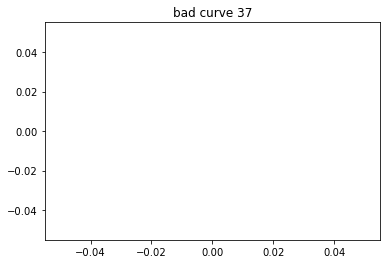

no fit
RFP
well #36
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                               legend
3    A4  36       1            0         0          3        NaN     NaN         NaN         NaN  B: Elongation-Division we call it 2


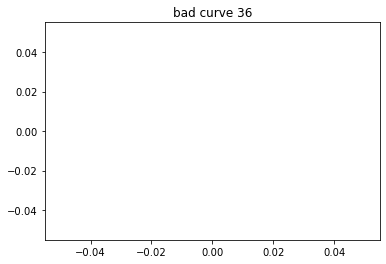

no fit
RFP
well #28
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9      legend
11   A12  28       3            0         0          3        NaN     NaN         NaN         NaN  E Clumping


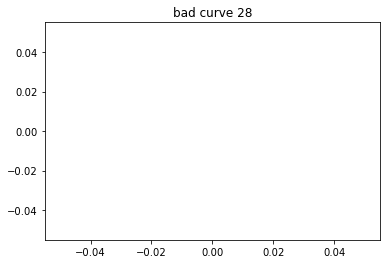

no fit
RFP
well #16
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
23   A24  16       2            0         0          3        NaN  2 filaments         NaN         NaN    NaN


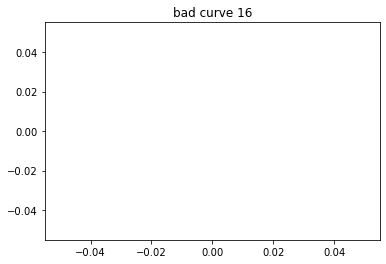

no fit
RFP
well #10
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
29   A30  10       1            0         0          3        NaN     NaN         NaN         NaN    NaN


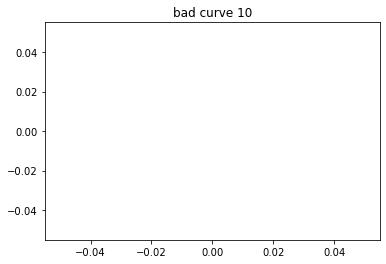

no fit
RFP
well #4
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
35   A36   4       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


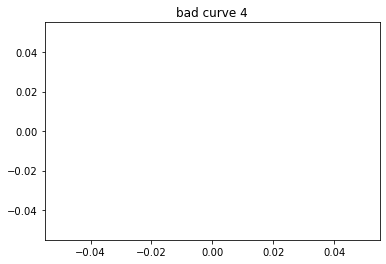

no fit
RFP
well #71
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
45    B7  71       5            0         0          3        NaN     NaN         NaN         NaN    NaN


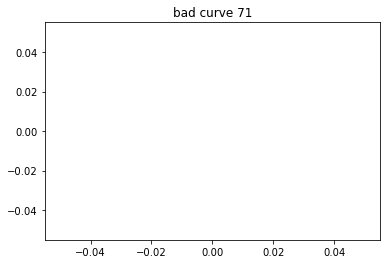

no fit
RFP
well #70
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
46    B8  70       3            0         0          3        NaN     NaN         NaN         NaN    NaN


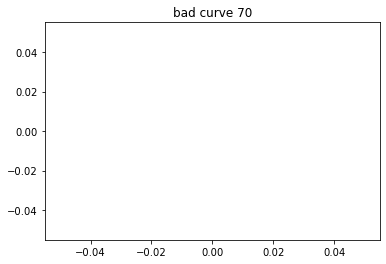

no fit
RFP
well #67
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
49   B11  67       1            0         0          3        NaN  1 filaments         NaN         NaN    NaN


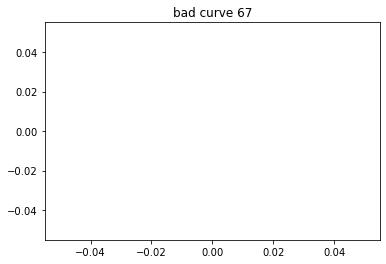

no fit
RFP
well #64
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
52   B14  64       2            0         0          3        NaN  3 filaments         NaN         NaN    NaN


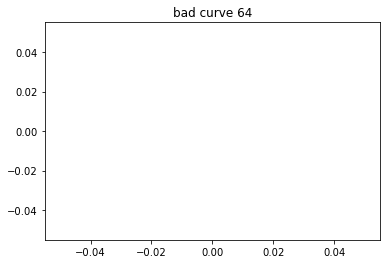

no fit
RFP
well #60
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
56   B18  60       1            0         0          3        NaN  3 filaments         NaN         NaN    NaN


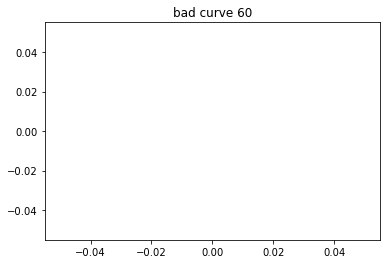

no fit
RFP
well #109
   coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
84    C8  109       2            0         0          3        NaN     NaN         NaN         NaN    NaN


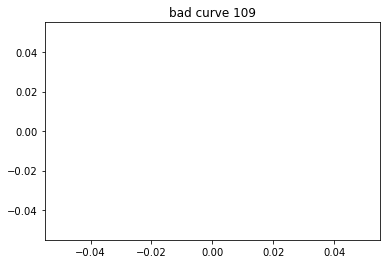

no fit
RFP
well #108
   coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
85    C9  108       1            0         0          3        NaN     NaN         NaN         NaN    NaN


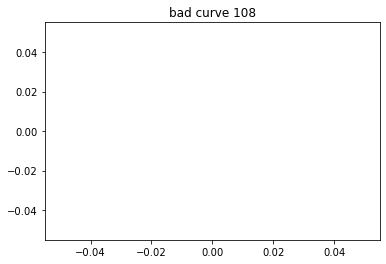

no fit
RFP
well #107
   coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
86   C10  107       3            0         0          3        NaN     NaN         NaN         NaN    NaN


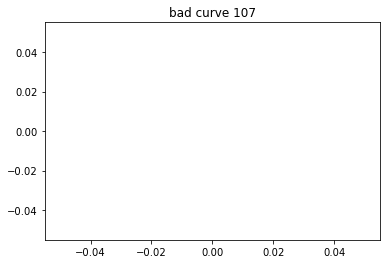

no fit
RFP
well #106
   coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
87   C11  106       2            0         0          3        NaN     NaN         NaN         NaN    NaN


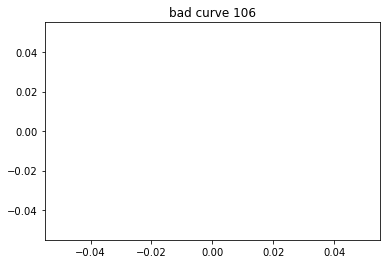

no fit
RFP
well #100
   coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
93   C17  100       1            0         0          3        NaN     NaN         NaN         NaN    NaN


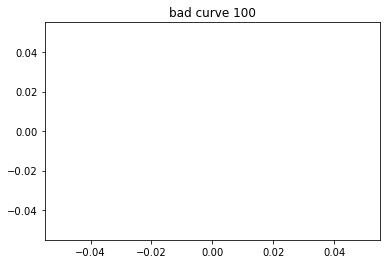

no fit
RFP
well #97
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
96   C20  97       2            0         0          3        NaN     NaN         NaN         NaN    NaN


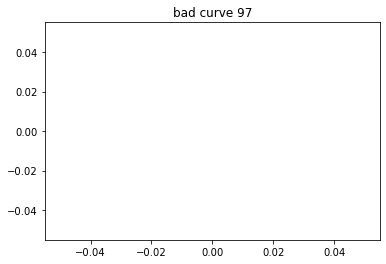

no fit
RFP
well #85
    coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
108   C32  85       1            0         0          3        NaN     NaN         NaN         NaN    NaN


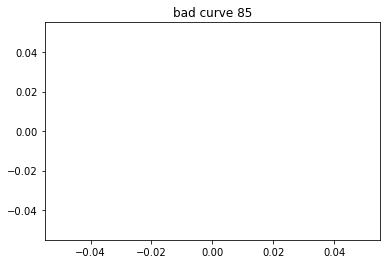

no fit
RFP
well #84
    coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
109   C33  84       1            0         0          3        NaN     NaN         NaN         NaN    NaN


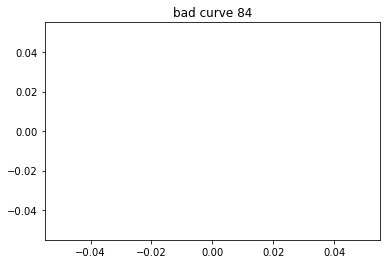

no fit
RFP
well #83
    coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
110   C34  83       1            0         0          3        NaN     NaN         NaN         NaN    NaN


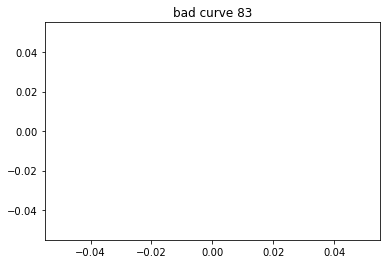

no fit
RFP
well #154
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
116    D1  154       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


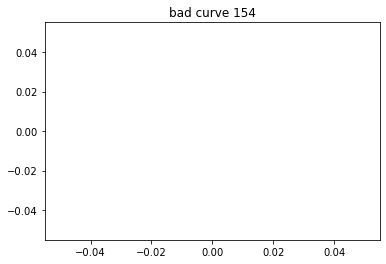

no fit
RFP
well #151
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
119    D4  151       4            0         0          3        NaN  4 filaments         NaN         NaN    NaN


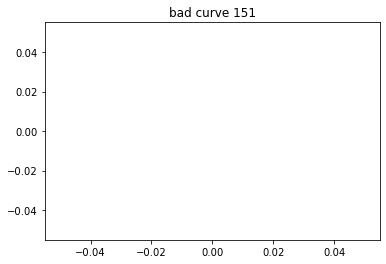

no fit
RFP
well #149
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6                                                                                 comment  Unnamed: 8  Unnamed: 9 legend
121    D6  149       1            0         0          3        NaN  The cell elongates, later divides and later the cells merged with the longest filament         NaN         NaN    NaN


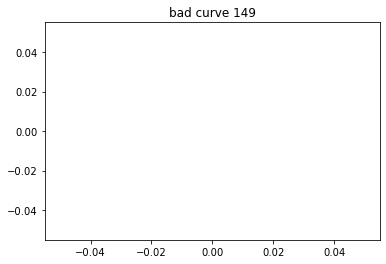

no fit
RFP
well #148
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6       comment  Unnamed: 8  Unnamed: 9 legend
122    D7  148       1            0         0          3        NaN  One filament         NaN         NaN    NaN


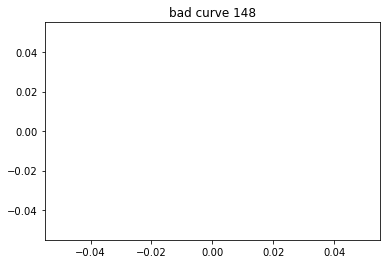

no fit
RFP
well #147
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
123    D8  147       3            0         0          3        NaN  2 filaments         NaN         NaN    NaN


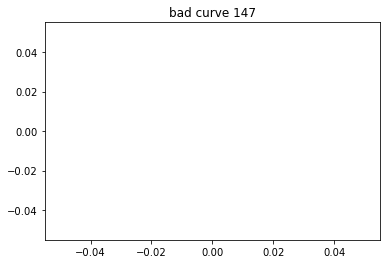

no fit
RFP
well #139
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
131   D16  139       2            0         0          3        NaN  3 filaments         NaN         NaN    NaN


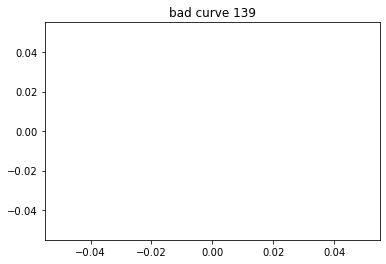

no fit
RFP
well #135
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6       comment  Unnamed: 8  Unnamed: 9 legend
135   D20  135       3            0         0          3        NaN  3 filaments          NaN         NaN    NaN


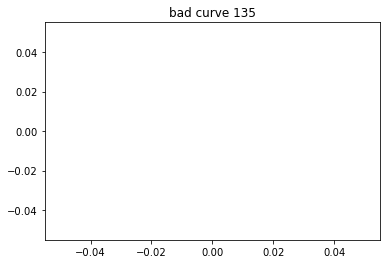

no fit
RFP
well #118
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
152   D37  118       2            1         0          3        NaN  1 filament         NaN         NaN    NaN
no fit
RFP
well #117
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6    comment  Unnamed: 8  Unnamed: 9 legend
153   D38  117       2            0         1          3        NaN  Bleaching         NaN         NaN    NaN


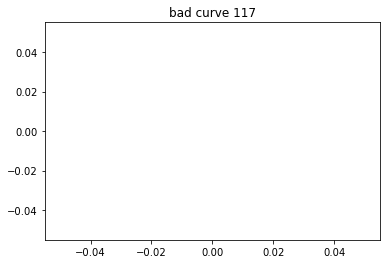

no fit
RFP
well #178
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
169   E16  178       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


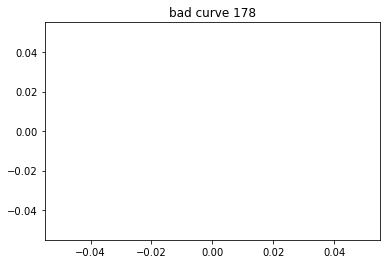

no fit
RFP
well #174
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
173   E20  174       1            0         0          3        NaN  2 filaments         NaN         NaN    NaN


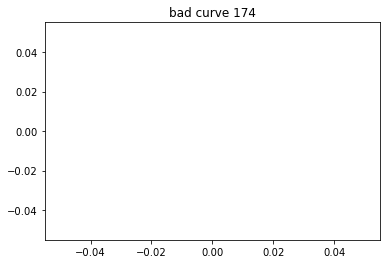

no fit
RFP
well #173
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
174   E21  173       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


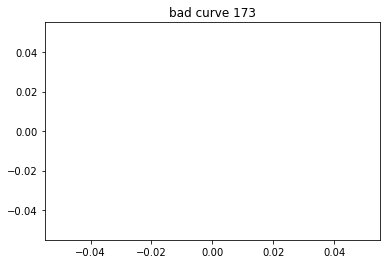

no fit
RFP
well #168
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6                comment  Unnamed: 8  Unnamed: 9 legend
179   E26  168       1            0         0          3        NaN  One bleached filament         NaN         NaN    NaN


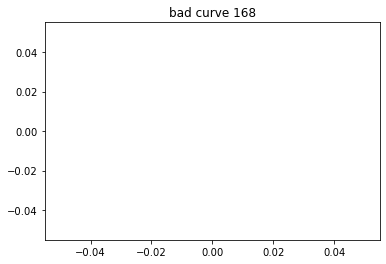

no fit
RFP
well #164
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
183   E30  164       1            0         0          3        NaN  2 filaments         NaN         NaN    NaN


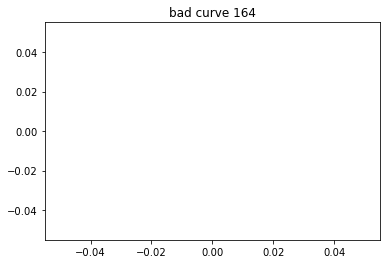

no fit
RFP
well #163
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
184   E31  163       2            0         0          3        NaN  2 filaments         NaN         NaN    NaN


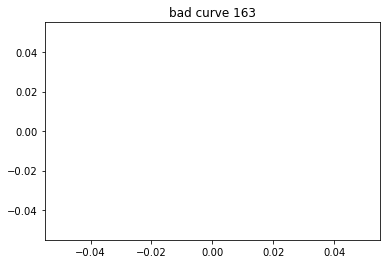

no fit
RFP
well #219
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
205   F13  219       2            0         0          3        NaN  1 filament         NaN         NaN    NaN


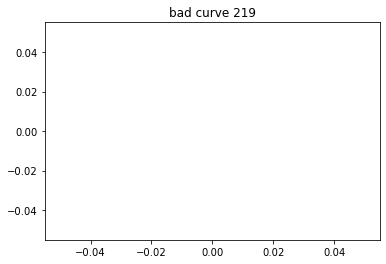

no fit
RFP
well #209
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
215   F23  209       3            0         0          3        NaN     NaN         NaN         NaN    NaN


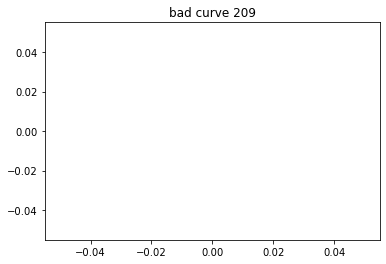

no fit
RFP
well #204
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
220   F28  204       1            0         0          3        NaN     NaN         NaN         NaN    NaN


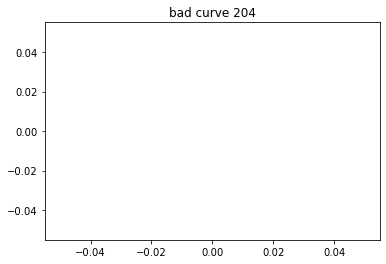

no fit
RFP
well #268
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
233    G3  268       2            0         0          3        NaN     NaN         NaN         NaN    NaN


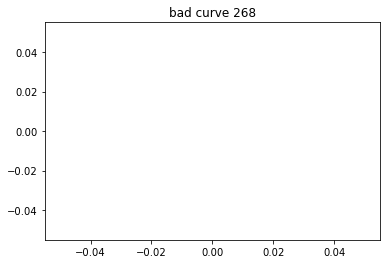

no fit
RFP
well #266
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
235    G5  266       1            0         0          3        NaN     NaN         NaN         NaN    NaN


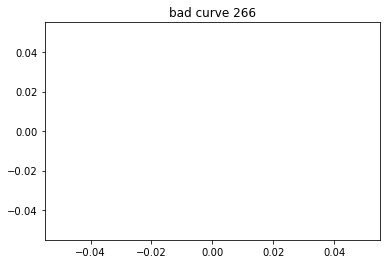

no fit
RFP
well #259
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6                                                                                            comment  Unnamed: 8  Unnamed: 9 legend
242   G12  259       1            0         0          3        NaN  There is elongation and division but at the end we can only acquired the image of 4ish filaments          NaN         NaN    NaN


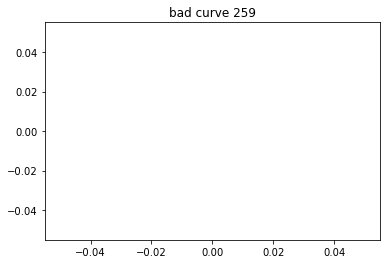

no fit
RFP
well #247
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
254   G24  247       2            0         0          3        NaN     NaN         NaN         NaN    NaN


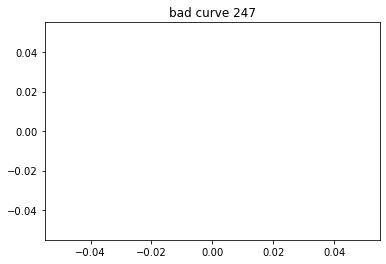

no fit
RFP
well #243
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
258   G28  243       1            0         0          3        NaN     NaN         NaN         NaN    NaN


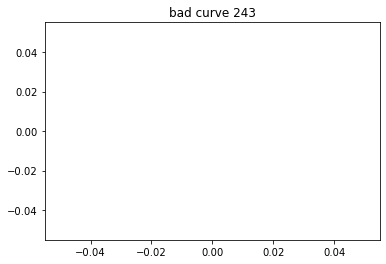

no fit
RFP
well #240
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6                             comment  Unnamed: 8  Unnamed: 9 legend
261   G31  240       1            0         0          3        NaN  There is an out of focus filament          NaN         NaN    NaN


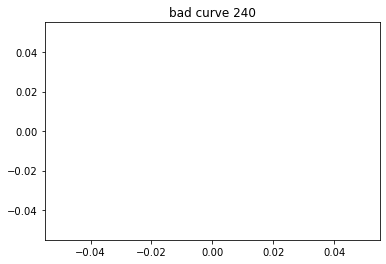

no fit
RFP
well #238
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
263   G33  238       1            0         0          3        NaN     NaN         NaN         NaN    NaN


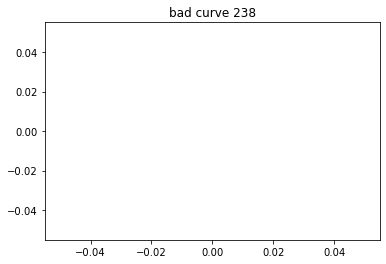

no fit
RFP
well #237
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
264   G34  237       1            0         0          3        NaN     NaN         NaN         NaN    NaN


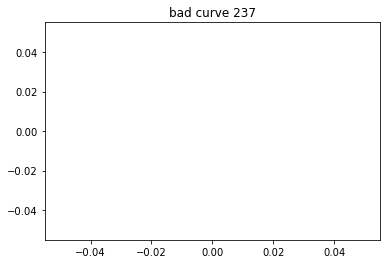

no fit
RFP
well #299
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
279   H10  299       1            0         0          3        NaN     NaN         NaN         NaN    NaN


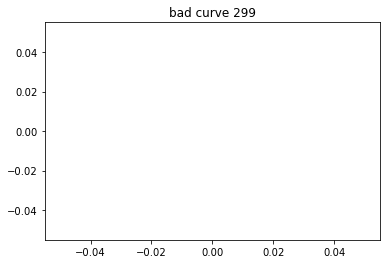

no fit
RFP
well #279
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6                                                                    comment  Unnamed: 8  Unnamed: 9 legend
299   H30  279       1            0         0          3        NaN  There is division and elongation but does not ends up in positive droplet         NaN         NaN    NaN


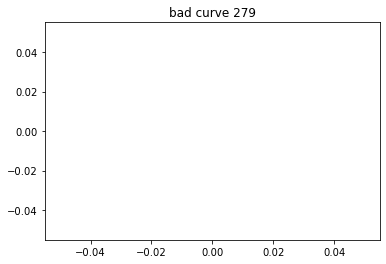

no fit
RFP
well #276
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6             comment  Unnamed: 8  Unnamed: 9 legend
302   H33  276       1            0         0          3        NaN  Bleached filaments         NaN         NaN    NaN


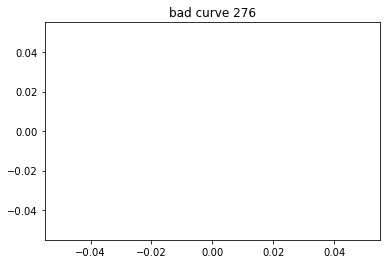

no fit
RFP
well #275
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
303   H34  275       2            0         0          3        NaN  2 filaments         NaN         NaN    NaN


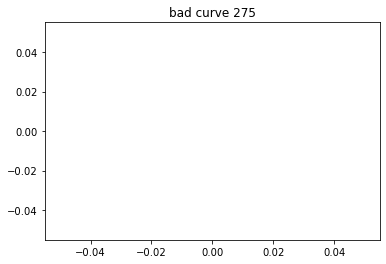

no fit
RFP
well #274
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
304   H35  274       1            0         0          3        NaN  2 filaments         NaN         NaN    NaN


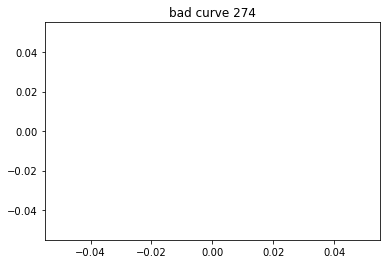

no fit
RFP
well #326
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
329   I22  326       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


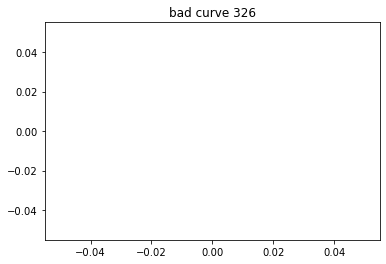

no fit
RFP
well #325
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
330   I23  325       2            0         0          3        NaN  5 filaments         NaN         NaN    NaN


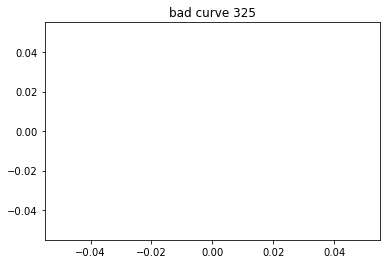

no fit
RFP
well #322
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
333   I26  322       1            0         0          3        NaN  2 filaments         NaN         NaN    NaN


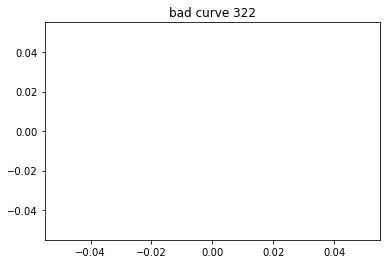

no fit
RFP
well #313
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6      comment  Unnamed: 8  Unnamed: 9 legend
342   I35  313       1            0         0          3        NaN  2 filaments         NaN         NaN    NaN


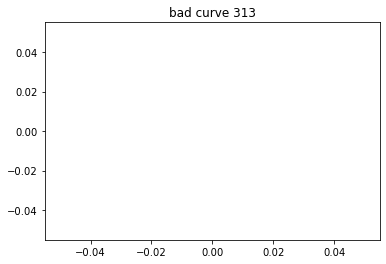

no fit
RFP
well #312
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
343   I36  312       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


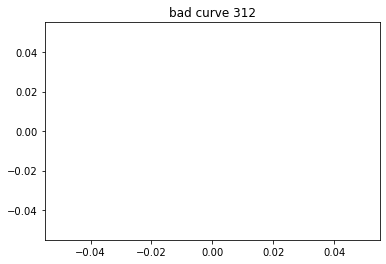

no fit
RFP
well #311
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6     comment  Unnamed: 8  Unnamed: 9 legend
344   I37  311       1            0         0          3        NaN  1 filament         NaN         NaN    NaN


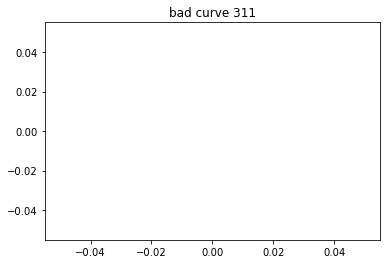

no fit
RFP
well #382
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
349    J3  382       1            0         0          3        NaN     NaN         NaN         NaN    NaN


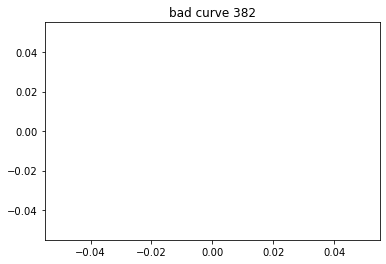

no fit
RFP
well #380
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
351    J5  380       1            0         0          3        NaN     NaN         NaN         NaN    NaN


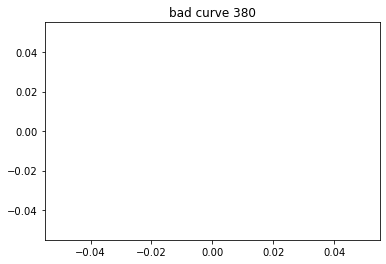

no fit
RFP
well #377
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6        comment  Unnamed: 8  Unnamed: 9 legend
354    J8  377       3            0         0          3        NaN  Some dissaper         NaN         NaN    NaN


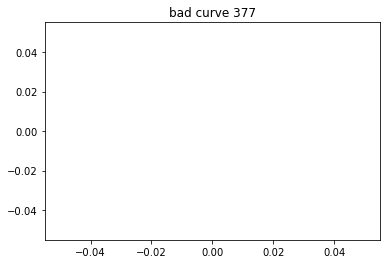

no fit
RFP
well #367
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
365   J19  367       2            0         0          3        NaN     NaN         NaN         NaN    NaN


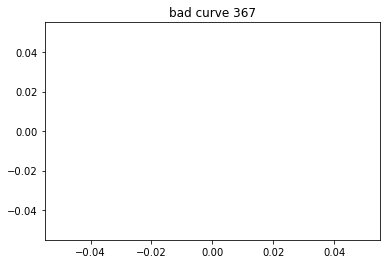

no fit
RFP
well #357
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
375   J29  357       4            0         0          3        NaN     NaN         NaN         NaN    NaN


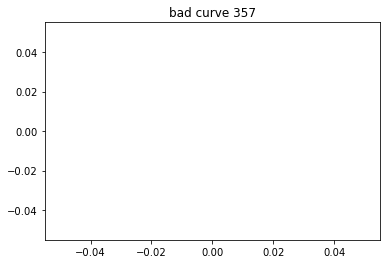

no fit
RFP
well #417
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
391    K7  417       1            0         0          3        NaN     NaN         NaN         NaN    NaN


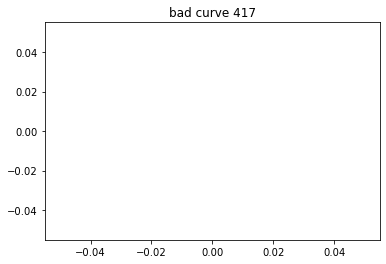

no fit
RFP
well #405
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
403   K19  405       1            0         0          3        NaN     NaN         NaN         NaN    NaN


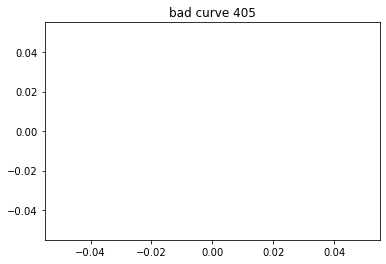

no fit
RFP
well #390
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
418   K34  390       1            0         0          3        NaN     NaN         NaN         NaN    NaN


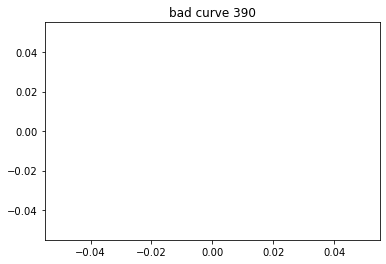

no fit
RFP
well #459
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
426    L3  459       1            0         0          3        NaN     NaN         NaN         NaN    NaN


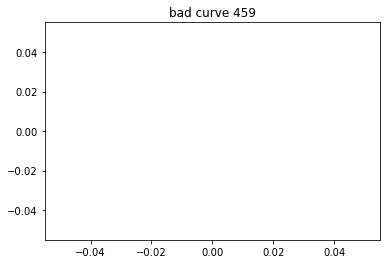

no fit
RFP
well #457
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
428    L5  457       2            0         0          3        NaN     NaN         NaN         NaN    NaN


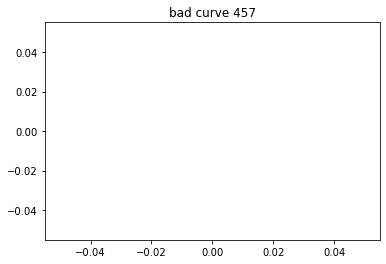

no fit
RFP
well #455
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
430    L7  455       2            0         0          3        NaN     NaN         NaN         NaN    NaN


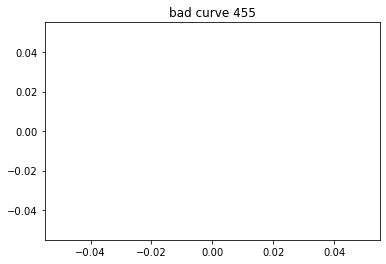

no fit
RFP
well #450
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
435   L12  450       1            0         0          3        NaN     NaN         NaN         NaN    NaN


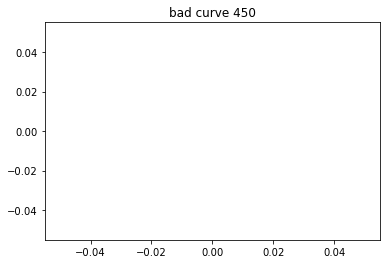

no fit
RFP
well #449
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
436   L13  449       1            0         0          3        NaN     NaN         NaN         NaN    NaN


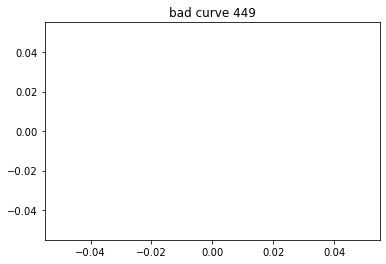

no fit
RFP
well #444
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
441   L18  444       2            0         0          3        NaN     NaN         NaN         NaN    NaN


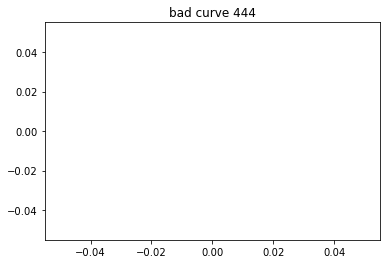

no fit
RFP
well #436
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
449   L26  436       2            0         0          3        NaN     NaN         NaN         NaN    NaN


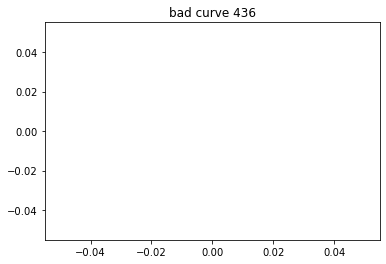

no fit
RFP
well #426
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
459   L36  426       1            0         0          3        NaN     NaN         NaN         NaN    NaN


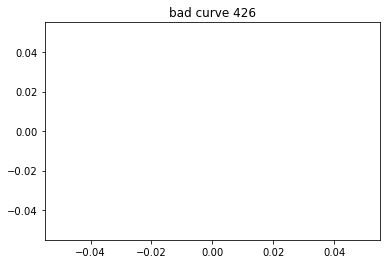

no fit
RFP
well #468
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
494   M33  468       2            0         0          3        NaN     NaN         NaN         NaN    NaN


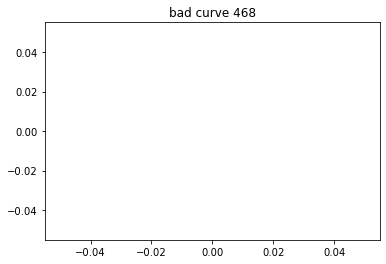

no fit
RFP
well #466
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
496   M35  466       2            0         0          3        NaN     NaN         NaN         NaN    NaN


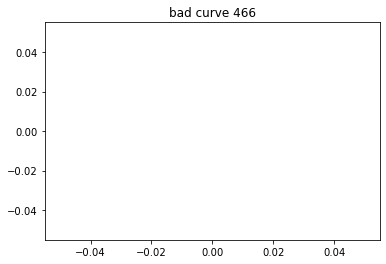

no fit


In [14]:
for i in table.query('phenotype == 3').id.unique()[:]:
    print('RFP')
    try:
        rfp_fit, rtime, rcurve, frcurve = correct_photobleaching(i, intensities=positive_intensities, plot=1)
        print('GFP')
        gfp_fit, gtime, gcurve, fgcurve = correct_photobleaching(i, intensities=gfp_intensities, plot=1)

        plt.semilogy( frcurve, 
                             label=f'rfp growth fit', lw=10, alpha=0.5)
        plt.semilogy( rcurve - rfp_fit[0], 
                             label=f'rfp curve', lw=1, alpha=1)
        plt.semilogy( fgcurve, 
                             label=f'gfp growth fit', lw=10, alpha=0.5)
        plt.semilogy( gcurve - gfp_fit[0], 
                             label=f'gfp curve', lw=1, alpha=1)
        plt.legend()
        plt.show()

        l = min((len(gcurve), len(rcurve)))

        plt.plot((gcurve - gfp_fit[0])[:l] / (rcurve - rfp_fit[0])[:l] )
        plt.title('GFP / RFP')
        plt.show()
    except ValueError:
        print('no fit')

In [13]:
table.query('final_state == 1').query('phenotype == 3').id.unique()[:]

array([118])

RFP
well #7
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
32   A33   7       1            1         1          1        NaN     NaN         NaN         NaN    NaN
growth fit: [-0.75760361  0.51078561  0.13139724  0.05004207  0.23742495 20.        ]
fit_result = [ 1.15545071e+02 -3.80047309e-02]


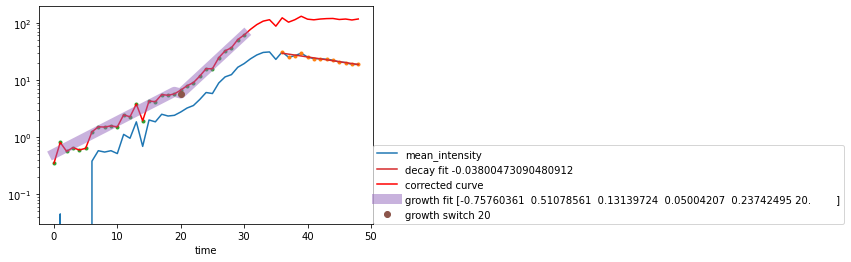

GFP
well #7
   coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
32   A33   7       1            1         1          1        NaN     NaN         NaN         NaN    NaN
growth fit: [-1.86676279  0.68640389  0.13728329  1.          0.14421856 25.        ]
fit_result = [ 1.62206198e+02 -6.61979082e-02]


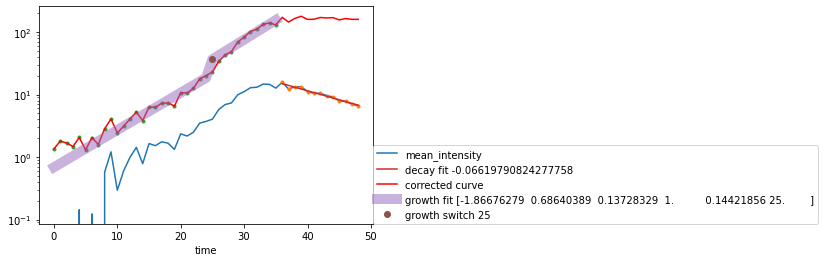

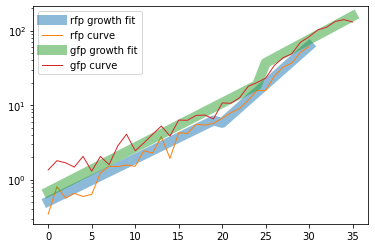

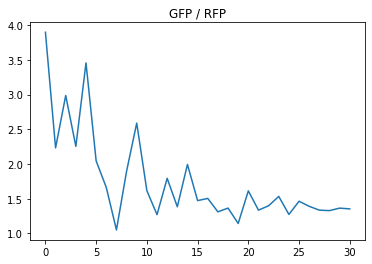

RFP
well #35
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                                                                      legend
4    A5  35       2            1         1         -1        NaN     NaN         NaN         NaN  C: Dead (normally elongation leadint to a beautiful filament) we call it 3
growth fit: [-7.58610357e-02  2.95166995e-03  5.01598714e-01  1.26480279e-01
  2.10566469e-01  1.50000000e+01]
fit_result = [ 6.34373931e+01 -1.81090451e-02]


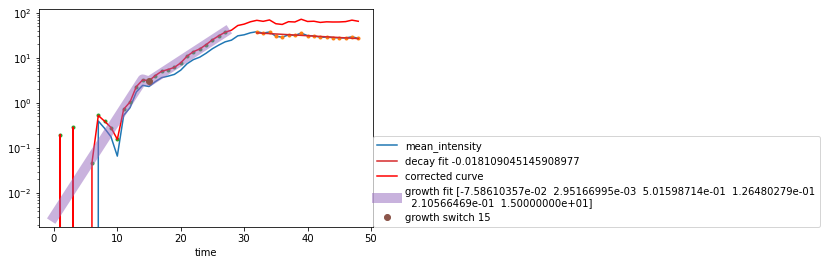

GFP
well #35
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                                                                      legend
4    A5  35       2            1         1         -1        NaN     NaN         NaN         NaN  C: Dead (normally elongation leadint to a beautiful filament) we call it 3
growth fit: [-2.          1.71397967  0.01418514  0.4061111   0.16568354 11.        ]
fit_result = [ 5.96083397e+01 -3.79608321e-02]


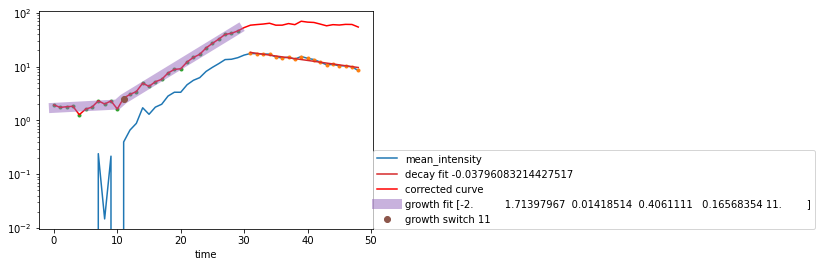

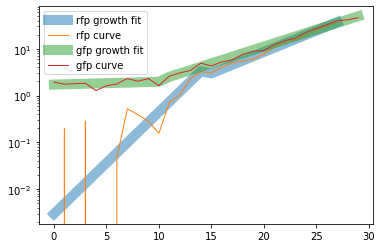

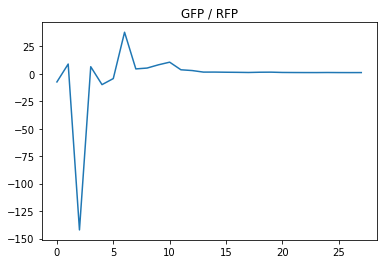

In [7]:
for i in [7, 35]:
    print('RFP')
    rfp_fit, rtime, rcurve, frcurve = correct_photobleaching(i, intensities=positive_intensities, plot=1)
    print('GFP')
    gfp_fit, gtime, gcurve, fgcurve = correct_photobleaching(i, intensities=gfp_intensities, plot=1)
    
    plt.semilogy( frcurve, 
                         label=f'rfp growth fit', lw=10, alpha=0.5)
    plt.semilogy( rcurve - rfp_fit[0], 
                         label=f'rfp curve', lw=1, alpha=1)
    plt.semilogy( fgcurve, 
                         label=f'gfp growth fit', lw=10, alpha=0.5)
    plt.semilogy( gcurve - gfp_fit[0], 
                         label=f'gfp curve', lw=1, alpha=1)
    plt.legend()
    plt.show()
    
    l = min((len(gcurve), len(rcurve)))
    
    plt.plot((gcurve - gfp_fit[0])[:l] / (rcurve - rfp_fit[0])[:l] )
    plt.title('GFP / RFP')
    plt.show()

well #39
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
0    A1  39       2            1         1          2        NaN     NaN         NaN         NaN    NaN
growth fit: [-6.26821489e-08  3.71926215e-04  7.28114220e-01  6.62385504e-02
  2.91214216e-01  1.40000000e+01]
well #35
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                                                                      legend
4    A5  35       2            1         1         -1        NaN     NaN         NaN         NaN  C: Dead (normally elongation leadint to a beautiful filament) we call it 3
growth fit: [-7.58610357e-02  2.95166995e-03  5.01598714e-01  1.26480279e-01
  2.10566469e-01  1.50000000e+01]
well #34
  coord  id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9                                                                                                     

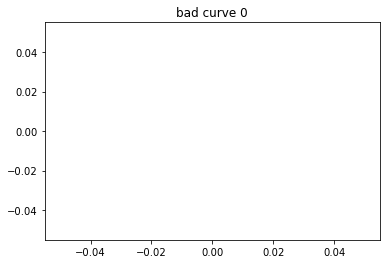

well #368
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
364   J18  368       3            1         1         -1        NaN     NaN         NaN         NaN    NaN
growth fit: [-1.00458132e-05  7.64651453e-01  1.38811921e-01  9.99999331e-01
  1.39155544e-01  2.20000000e+01]
well #365
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
367   J21  365       1            1         1          1        NaN     NaN         NaN         NaN    NaN
growth fit: [-1.99999999  0.66491015  0.13486927  0.25246779  0.18339924 23.        ]
well #364
    coord   id  ncells  final_state  clumping  phenotype Unnamed: 6 comment  Unnamed: 8  Unnamed: 9 legend
368   J22  364       1            1         1          1        NaN     NaN         NaN         NaN    NaN
growth fit: [-8.13651281e-01  1.44837293e-02  3.14541696e-01  6.38979648e-03
  2.91336387e-01  1.80000000e+01]
well #362
    coord 

In [24]:
corr_curves = [correct_photobleaching(i, plot=0)[0] for i in table.query('final_state == 1').id.unique()[:]]

In [25]:
cdf = pd.DataFrame(data=corr_curves, columns=['baseline', 'a1', 'b1', 'a2', 'b2', 'switch'], index=table.query('final_state == 1').id.unique())

In [26]:
len(cdf)

318

In [27]:
df = pd.concat((cdf, table.query('final_state == 1')), axis=1)
df.columns

Index(['baseline', 'a1', 'b1', 'a2', 'b2', 'switch', 'coord', 'id', 'ncells',
       'final_state', 'clumping', 'phenotype', 'Unnamed: 6', 'comment',
       'Unnamed: 8', 'Unnamed: 9', 'legend'],
      dtype='object')

In [28]:
# df.to_csv('/home/aaristov/Multicell/SGR/20200807-CIPRO-7ngml-rep1_1.2_cellsperdrop/2exp_fits.csv')

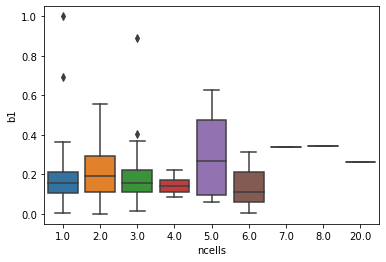

In [29]:
sns.boxplot(x='ncells', y='b1', data=df)

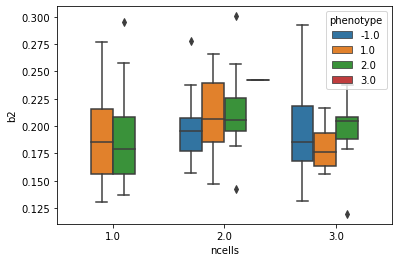

In [98]:
sns.boxplot(x='ncells', y='b2', hue='phenotype', data=df.query('ncells < 4'))

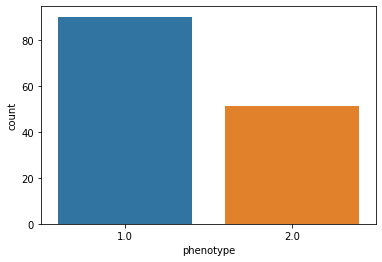

In [101]:
sns.countplot(x='phenotype', data=df.query('ncells == 1'))

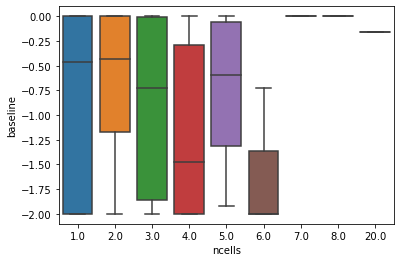

In [102]:
sns.boxplot(x='ncells', y='baseline', data=df)

(0.0, 0.4)

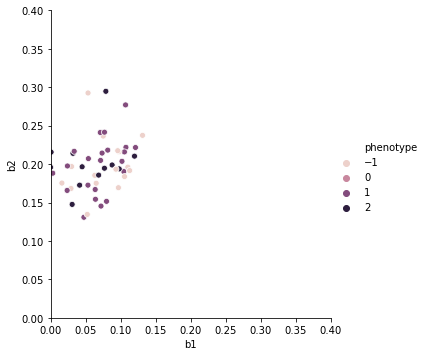

In [83]:
sns.relplot(x='b1', y='b2',  hue='phenotype', data=(slow_lag := df.query('0 < ncells < 4').query('b1 < b2 * .6')))
plt.xlim(0, 0.4)
plt.ylim(0, 0.4)

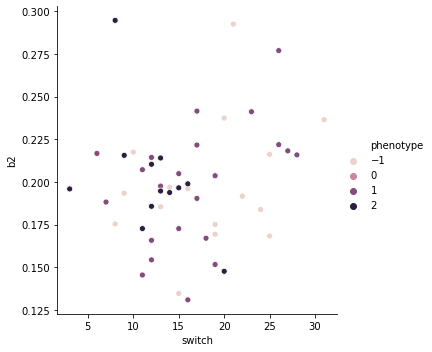

In [84]:
sns.relplot(x='switch', y='b2',hue='phenotype', data=slow_lag)

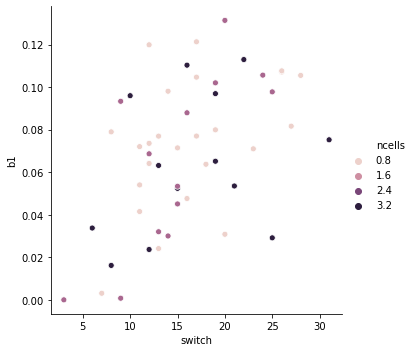

In [86]:
sns.relplot(x='switch', y='b1',hue='ncells', data=slow_lag)

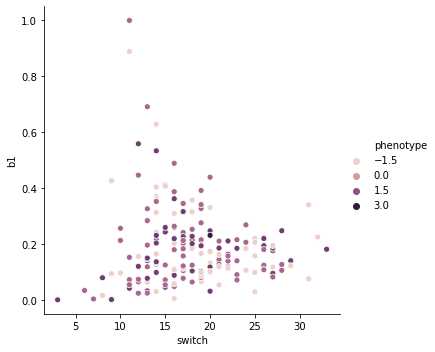

In [88]:
sns.relplot(x='switch', y='b1',hue='phenotype', data=df)

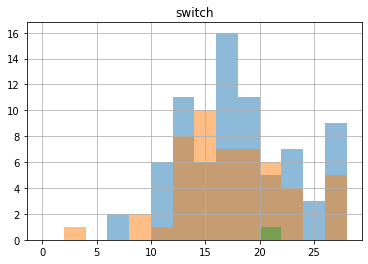

In [38]:
p = dict(histtype='stepfilled', alpha=.5, bins=np.arange(0,30,2))
[df.query(f'phenotype == {i}').switch.hist(**p) for i in [1,2,3]]
plt.title('switch')
plt.show()

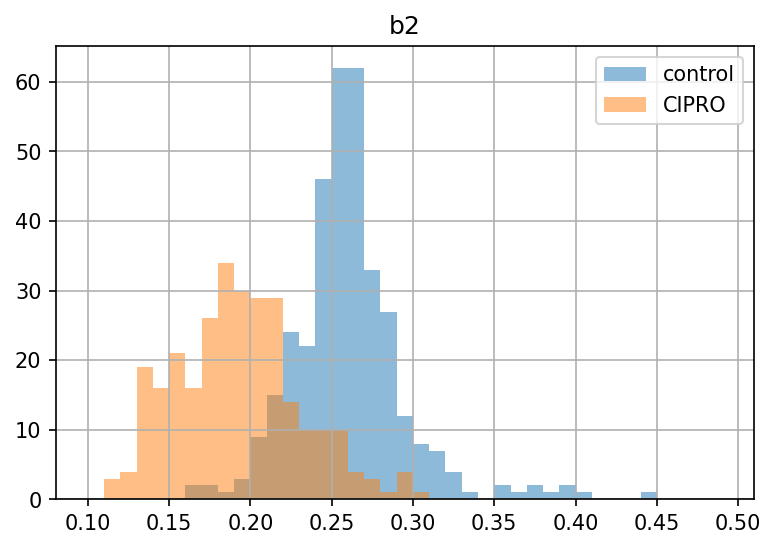

In [91]:
plt.figure(dpi=150)
pd.read_csv('/home/aaristov/Multicell/SGR/20200805-Control_1.2cellsperdrop/0805-control/exp_fits.csv').c.hist(**p, label='control')

p = dict(histtype='stepfilled', alpha=.5, bins=np.arange(0.1,0.5,0.01))#, density=True)
df.b2.hist(**p, label='CIPRO')
plt.title('b2')
# plt.xlim(0,1)

plt.legend()

(0.0, 1.0)

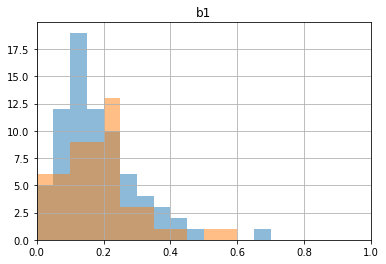

In [95]:
p = dict(histtype='stepfilled', alpha=.5, bins=np.arange(0,1,0.05))
df.query('phenotype == 1').b1.hist(**p)
df.query('phenotype == 2').b1.hist(**p)
plt.title('b1')
plt.xlim(0,1)

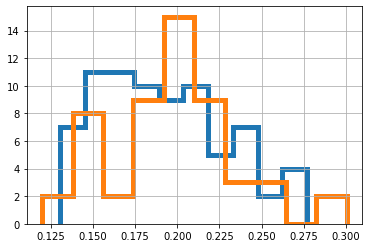

In [92]:
p = dict(histtype='step', alpha=1, bins=10, lw=5)
df.query('phenotype == 1').b2.hist(**p)
df.query('phenotype == 2').b2.hist(**p)


/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


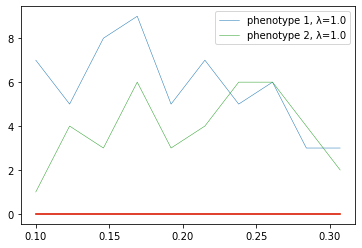

In [94]:
def get_poisson(df=df, phenotype=1, bins=np.linspace(0.1,0.33, num=11), mul=10):
    data = df.query(f'phenotype == {i}').b1.values
    hist, _= np.histogram(data, bins=bins-0.05, density=False)
    
    vector = bins[:-1]
    
    popt, pcov = curve_fit(poisson.pmf,  vector, hist, p0=(1.,))
    l = popt[0]
    plt.plot(vector, hist, label=f'phenotype {i}, λ={l}', lw=0.5)
    plt.plot(vector, len(data) * poisson.pmf(vector, l))
    plt.legend()

for i in [1,2,]:
    get_poisson(phenotype=i)

<ipython-input-7-ab343a7f3daf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
<ipython-input-7-ab343a7f3daf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
<ipython-input-7-ab343a7f3daf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
<ipython-input-7-ab343a7f3daf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
<ipython-input-7-ab343a7f3daf>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.d

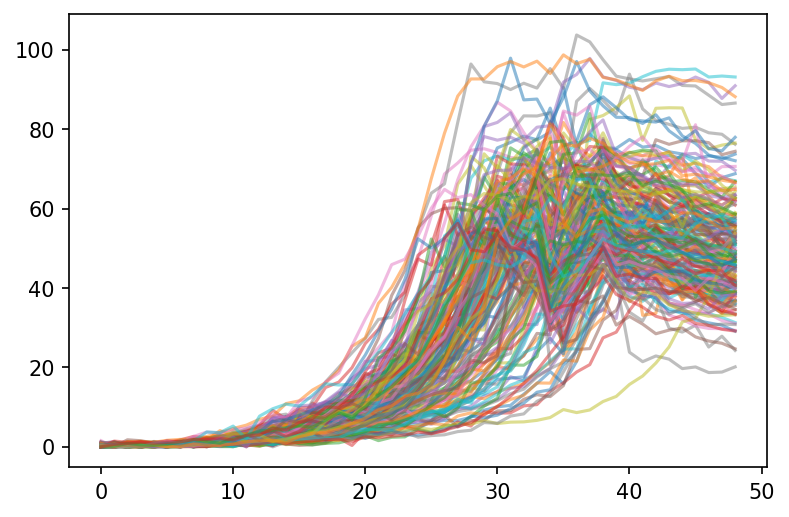

In [7]:
plt.figure(dpi=150)
for label in intensities.label.unique():
    curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
    
    if curve.max() > 50:
        (c := curve - curve.min())
        plt.plot(c, alpha=.5)
plt.show()

<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
<ipython-input-6-a539bbb4c44a>:3: UserWarning: Boolean Series key will be r

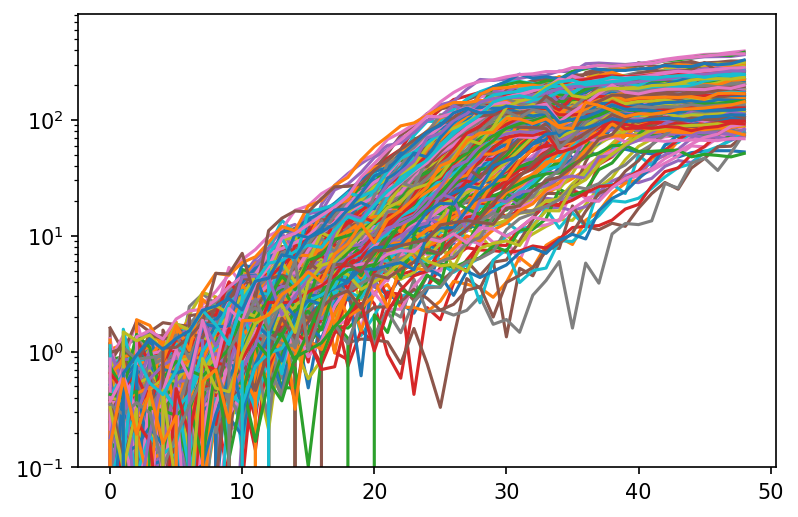

In [6]:
plt.figure(dpi=150)
for label in intensities.label.unique():
    curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP']
    
    if curve.mean_intensity.max() > 10:
        (c := curve.mean_intensity.values - curve.mean_intensity.values.min())
        plt.semilogy(c * bleach_fun(np.arange(len(curve)), -.03))
plt.ylim(0.1,)
plt.show()

In [119]:
decays_list = list(map(crop_decay, intensities.label.unique()[:]))
decays_list = list(filter(lambda x: x is not None, decays_list))

<ipython-input-118-eabdf93e3a61>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curve = intensities.query(f'label == {label}')[intensities.dye == dye]
<ipython-input-118-eabdf93e3a61>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decay['normalized_intensity'] = decay.mean_intensity / peak
<ipython-input-118-eabdf93e3a61>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decay['x'] = x
<ipython-input-118-eabdf93e3a61>:15: SettingWithCopyWarning: 
A value is trying to be 

In [120]:
decays_list[0]

time  label  dye           bg          raw  mean_intensity  \
40000    31      1  GFP  1623.882038  1655.752441       31.870403   
40500    32      1  GFP  1624.572386  1655.380304       30.807918   
41000    33      1  GFP  1624.131367  1652.556140       28.424772   
41500    34      1  GFP  1626.498660  1653.675460       27.176800   
42000    35      1  GFP  1624.422252  1652.141945       27.719693   
42500    36      1  GFP  1624.355228  1643.787833       19.432605   
43000    37      1  GFP  1624.530831  1650.145982       25.615151   
43500    38      1  GFP  1623.513405  1651.153962       27.640557   
44000    39      1  GFP  1624.315013  1648.404525       24.089512   
44500    40      1  GFP  1623.990617  1645.944705       21.954089   
45000    41      1  GFP  1623.156836  1643.787364       20.630527   
45500    42      1  GFP  1626.162198  1644.391570       18.229371   
46000    43      1  GFP  1623.132708  1644.973714       21.841006   
46500    44      1  GFP  1623.525469  1645.073413       21.547944   
47000    45      1  GFP  1623.394102  1642.711134       19.317032   
47500    46      1  GFP  1623.053619  1642.532482       19.478863   
48000    47      1  GFP  1623.564343  1642.060646       18.496303   
48500    48      1  GFP  1624.455764  1646.166354       21.710590   

       normalized_intensity             x           y  
40000              1.000000  10284.591532  161.363688  
40500              0.966662  10284.591532  161.363688  
41000              0.891886  10284.591532  161.363688  
41500              0.852728  10284.591532  161.363688  
42000              0.869763  10284.591532  161.363688  
42500              0.609738  10284.591532  161.363688  
43000              0.803728  10284.591532  161.363688  
43500              0.867280  10284.591532  161.363688  
44000              0.755858  10284.591532  161.363688  
44500              0.688855  10284.591532  161.363688  
45000              0.647326  10284.591532  161.363688  
45500              0.571984  10284.591532  161.363688  
46000              0.685307  10284.591532  161.363688  
46500              0.676111  10284.591532  161.363688  
47000              0.606112  10284.591532  161.363688  
47500              0.611190  10284.591532  161.363688  
48000              0.580360  10284.591532  161.363688  
48500              0.681215  10284.591532  161.363688

In [145]:
fits = list(map(lambda x: (x.label.values[0], x.x.values[0], x.y.values[0], *fit.fit_exp_on_baseline(x.mean_intensity.values, x=x.time.values, plot=False), max(x.mean_intensity.values)), decays_list))

No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit


/home/aaristov/miniconda3/envs/nd2/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit
No fit

Text(0, 0.5, 'amplitude')

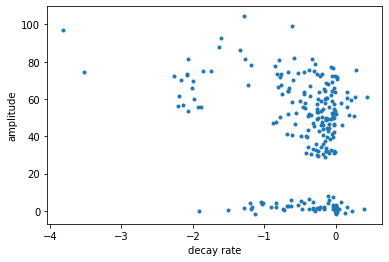

In [148]:
df = pd.DataFrame(columns=list('lxyabcm'), data=fits)
plt.plot('c', 'm', '.', data=df)
plt.xlabel('decay rate')
plt.ylabel('amplitude')


Text(0, 0.5, 'decay rate')

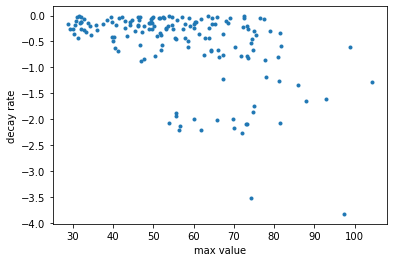

In [152]:
df = pd.DataFrame(columns=list('lxyabcm'), data=fits).query('m>20').query('c<0')
plt.plot('m', 'c', '.', data=df,)
plt.xlabel('max value')
plt.ylabel('decay rate')


In [153]:
df

l             x            y          a             b         c  \
0      1  10284.591532   161.363688  18.320983  1.074043e+03 -0.140668   
1      2  10018.633375   166.669406  36.903146  1.288540e+05 -0.268048   
7      8   8428.055872   194.512035  45.157918  1.377683e+08 -0.500547   
8      9   8162.095995   199.502236  17.462360  2.668924e+03 -0.177429   
10    11   7631.556029   207.494204  23.394078  2.340106e+03 -0.178319   
..   ...           ...          ...        ...           ...       ...   
447  493   2110.024570  2963.125794  62.093093  4.186677e+01 -1.225408   
450  496   1315.243347  2977.829566  13.300583  6.913517e+01 -0.028325   
452  498    785.595828  2988.189886  38.045937  1.460189e+02 -0.040541   
453  499    521.197437  2993.293629  12.324502  1.363155e+02 -0.046285   
454  500    253.388678  2998.844837  30.439274  1.663145e+10 -0.574002   

             m  
0    31.870403  
1    49.031281  
7    58.687874  
8    30.514091  
10   35.891372  
..         ...  
447  67.261333  
450  46.703391  
452  76.594868  
453  51.606447  
454  46.793156  

[160 rows x 7 columns]

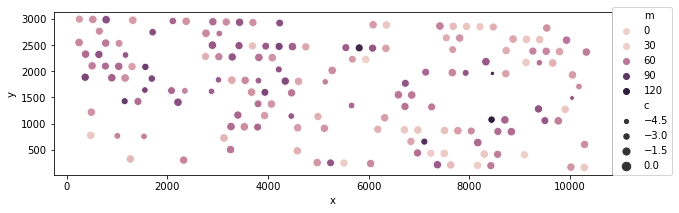

In [157]:
fig,ax = plt.subplots(figsize=(10,3))
sns.scatterplot(ax=ax, x='x', y='y', size='c', hue='m', data=df)
ax.legend(loc=(1,0))

In [ ]:
for label in df.l:
    print(label)
    try:
        c = df.query(f'l == {label}').c.values[0]
        curve = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].mean_intensity.values
        x = intensities.query(f'label == {label}')[intensities.dye == 'RFP'].time.values
        print(c)
        new_curve = curve * np.exp(0.03 * x)
        plt.plot(x, curve)
        plt.plot(x, new_curve)
        plt.show()
    except KeyError:
        print(f'no label {label}')